In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\thego\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
import re
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm
import collections
#import difflib
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import warnings
warnings.filterwarnings("ignore")

In [12]:
speeches = pd.read_csv('../data/speeches.csv')
print('Number of speeches in dataframe: ',speeches.shape[0])
speeches.head()

Number of speeches in dataframe:  156


,Unnamed: 0,Date,Title,Speech
0,0,"March 1, 2021",Address by Minister for Foreign Affairs Hon. M...,\n\nAddress by Minister for Foreign Affairs Ho...
1,1,"February 23, 2021","Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
2,2,"January 21, 2021",Opening Statement by Hon. Mr. Pradeep Kumar Gy...,\n\nOpening Statement by Hon. Mr. Pradeep Kuma...
3,3,"January 21, 2021","Statement by Hon. Mr. Pradeep Kumar Gyawali, M...",\n\nStatement by Hon. Mr. Pradeep Kumar Gyawal...
4,4,"January 15, 2021",Talks Given by Minister for Foreign Affairs of...,\n\nTalks Given by Minister for Foreign Affair...


In [13]:
data = speeches.copy()
data = data.drop('Unnamed: 0', axis=1)
data['Date'] = pd.to_datetime(data.Date)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month 
data['Day'] = data['Date'].dt.weekday
data = data[['Date','Year','Month','Day','Title','Speech']]

#### Number of Speeches delivered by years

In [14]:
df = data.groupby('Year').size().reset_index(name='Frequency').sort_values('Year')
df

,Year,Frequency
0,2015,4
1,2016,29
2,2017,21
3,2018,35
4,2019,41
5,2020,21
6,2021,5


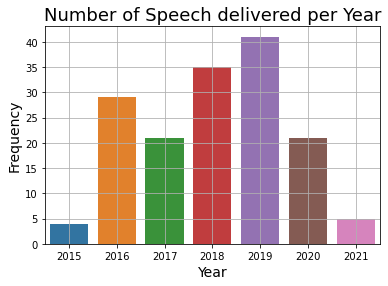

In [15]:
plt.figure(figsize=(6,4))
#plt.style.use('ggplot')
sns.barplot(df['Year'], df['Frequency'])
plt.title('Number of Speech delivered per Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.savefig('../Graphs/n_speeches_year.png')
plt.show()

#### Numbers of Speeches delivered by Months

In [16]:
df = data.groupby('Month').size().reset_index(name='Frequency').sort_values('Month')
months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August',
           9:'September', 10:'October', 11:'November', 12:'December'}

data['Month'] = data.Month.apply(lambda x: months[x])
df['Month'] = df.Month.apply(lambda x: months[x])
df

,Month,Frequency
0,January,6
1,February,9
2,March,11
3,April,15
4,May,17
5,June,12
6,July,9
7,August,14
8,September,26
9,October,16


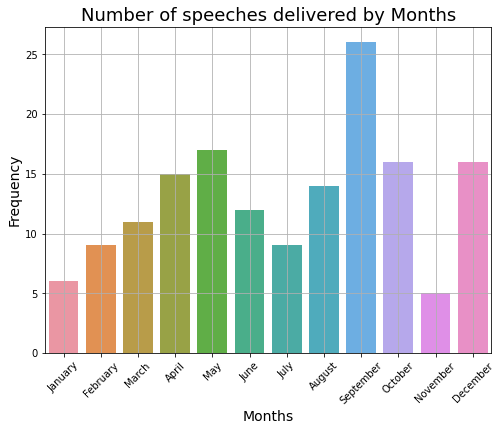

In [17]:
plt.figure(figsize=(8,6))
sns.barplot(df['Month'], df['Frequency'])
plt.title('Number of speeches delivered by Months', fontsize=18)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('../Graphs/no_speeches_months.png')
plt.show()

#### Number of Speeches by Days

In [18]:
df = data.groupby('Day').size().reset_index(name='Frequency').sort_values('Day')
days = {0:'Monday', 1:'Tuesday', 2:'Wednsday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data.Day= data.Day.apply(lambda x: days[x])
df.Day = df.Day.apply(lambda x: days[x])
df

,Day,Frequency
0,Monday,20
1,Tuesday,26
2,Wednsday,23
3,Thursday,25
4,Friday,30
5,Saturday,10
6,Sunday,22


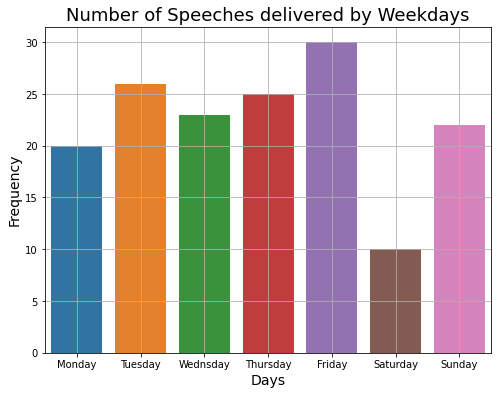

In [19]:
plt.figure(figsize=(8,6))
sns.barplot(df.Day, df.Frequency)
plt.title('Number of Speeches delivered by Weekdays', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.savefig('../Graphs/no_speeches_days.png')
plt.show()

#### Number of Speeches by Month_year

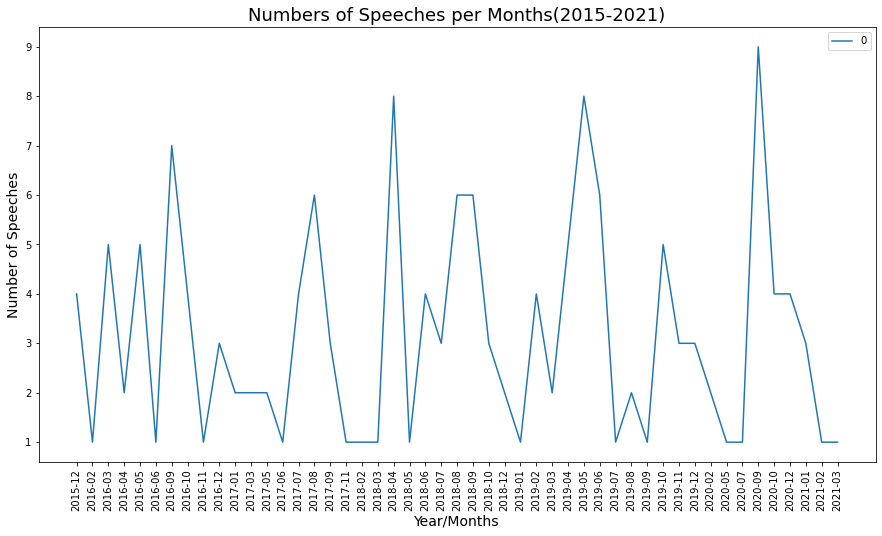

In [26]:
data['M/Y'] = data['Date'].dt.to_period('m')
df = data.groupby('M/Y').size().reset_index()
labels = list(df['M/Y'])
#plt.figure(figsize=(15,8))
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
df.plot()
plt.title('Numbers of Speeches per Months(2015-2021)', fontsize=18)
plt.xlabel('Year/Months', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.savefig('../Graphs/speeches_MY.png')
plt.show()

In [27]:
def Preprocess(text):
    no_stops = []
    sent = text.lower()
    sent = re.sub(r"[^a-zA-Z]"," ",sent)
    #sent = str(text)
    for w in sent.split():
        if not w in stop_words:
            no_stops.append(w)
    long_words = [w for w in no_stops if len(w)>3]
    return (" ".join(long_words))

In [28]:
data['cleaned_speech']= data['Speech'].apply(lambda x: Preprocess(x))

In [30]:
sentences = data['Speech'].apply(lambda x:[sent_tokenize(x)])

#flattening the list of list into single list.
sentences = [sent for sublist in sentences for sent in sublist]
sentences = [sent for sublist in sentences for sent in sublist]

# removing new line characters from sentences
sentences = [re.sub(r"\n"," ",sent) for sent in sentences]
sentences = [sent.lower() for sent in sentences]

In [31]:
sentences[:10]

['  address by minister for foreign affairs hon.',
 'mr. pradeep kumar gyawali at the 73rd anniversary of nepal council of world affairs (ncwa) posted onmarch 1, 2021   address by minister for foreign affairs hon.',
 'mr. pradeep kumar gyawali at the 73rd anniversary of nepal council of world affairs (ncwa) kathmandu, 1 march 2021 president of the nepal council of world affairs, executive board members of the council, excellencies, distinguished guests, ladies and gentlemen.',
 'i am delighted to be back to this forum once again.',
 'i thank you mr. president and members of the council for organizing this event and for having me here.',
 'it is always a pleasure to be amongst a cross-section of personalities who have made contributions to nepal’s foreign policy and international relations from their respective capacities.',
 'i would like to acknowledge the role played by nepal council of world affairs in promoting healthy discourse on matters related to nepal’s foreign policy as well 

In [32]:
speech_tokens = data['cleaned_speech'].apply(lambda x:[word for word in x.split(' ')])
speech_tokens

0      [address, minister, foreign, affairs, pradeep,...
1      [statement, pradeep, kumar, gyawali, minister,...
2      [opening, statement, pradeep, kumar, gyawali, ...
3      [statement, pradeep, kumar, gyawali, minister,...
4      [talks, given, minister, foreign, affairs, nep...
                             ...                        
151    [press, note, posted, onfebruary, please, clic...
152    [address, nation, prime, minister, sharma, pos...
153    [spokesperson, statement, reference, nepal, ma...
154    [opening, statement, delivered, deputy, prime,...
155    [statement, prakash, singh, deputy, prime, min...
Name: cleaned_speech, Length: 156, dtype: object

In [33]:
all_tokens = [token for token_sublist in list(speech_tokens) for token in token_sublist ]

In [34]:
len(all_tokens)

109552

In [35]:
freq_dist = nltk.FreqDist(all_tokens)
freq_dist.most_common(100)

[('nepal', 2509),
 ('development', 1120),
 ('people', 755),
 ('countries', 653),
 ('economic', 617),
 ('peace', 614),
 ('human', 552),
 ('cooperation', 533),
 ('world', 518),
 ('rights', 507),
 ('government', 491),
 ('minister', 475),
 ('also', 475),
 ('international', 474),
 ('china', 470),
 ('foreign', 450),
 ('relations', 437),
 ('investment', 437),
 ('country', 404),
 ('political', 402),
 ('india', 394),
 ('trade', 390),
 ('national', 347),
 ('well', 331),
 ('would', 328),
 ('process', 325),
 ('important', 323),
 ('prime', 308),
 ('like', 305),
 ('global', 295),
 ('constitution', 283),
 ('president', 280),
 ('must', 278),
 ('support', 272),
 ('level', 266),
 ('nepali', 261),
 ('thank', 256),
 ('prosperity', 250),
 ('connectivity', 244),
 ('year', 243),
 ('policy', 242),
 ('need', 240),
 ('social', 237),
 ('security', 228),
 ('time', 228),
 ('ladies', 227),
 ('partnership', 226),
 ('gentlemen', 225),
 ('resources', 222),
 ('affairs', 221),
 ('efforts', 218),
 ('challenges', 211),
 (

In [36]:
# Listing most common n-grams 
ng2 = ngrams(all_tokens, 2)
ng3 = ngrams(all_tokens, 3)
ng2_list = [' '.join(grams) for grams in ng2]
ng3_list = [' '.join(grams) for grams in ng3]
#ng2_freq = collections.Counter(ng2)
#ng3_freq = collections.Counter(ng3)

In [37]:
ng2_freq = nltk.FreqDist(ng2_list)
ng2_freq.most_common(50)

[('human rights', 356),
 ('prime minister', 285),
 ('ladies gentlemen', 225),
 ('would like', 164),
 ('foreign affairs', 160),
 ('nepal china', 143),
 ('united nations', 141),
 ('minister foreign', 134),
 ('sustainable development', 127),
 ('climate change', 118),
 ('dear friends', 109),
 ('pradeep kumar', 108),
 ('kumar gyawali', 108),
 ('economic development', 108),
 ('nepal india', 108),
 ('peace process', 107),
 ('government nepal', 100),
 ('foreign policy', 99),
 ('socio economic', 85),
 ('cross border', 84),
 ('release speech', 81),
 ('categoriespress release', 80),
 ('minister nepal', 80),
 ('high level', 77),
 ('peace security', 73),
 ('migrant workers', 73),
 ('trade investment', 72),
 ('economic transformation', 68),
 ('last year', 67),
 ('people people', 67),
 ('prosperous nepal', 66),
 ('member states', 66),
 ('economic growth', 63),
 ('gyawali minister', 62),
 ('nepal happy', 58),
 ('belt road', 58),
 ('international community', 55),
 ('secretary general', 54),
 ('developm

In [38]:
ng3_freq = nltk.FreqDist(ng3_list)
ng3_freq.most_common(30)

[('minister foreign affairs', 134),
 ('pradeep kumar gyawali', 108),
 ('categoriespress release speech', 80),
 ('prime minister nepal', 76),
 ('kumar gyawali minister', 62),
 ('gyawali minister foreign', 62),
 ('prosperous nepal happy', 55),
 ('nepal happy nepali', 51),
 ('belt road initiative', 45),
 ('thank categoriespress release', 44),
 ('sustainable development goals', 41),
 ('human rights council', 40),
 ('socio economic transformation', 36),
 ('prime minister sharma', 34),
 ('release speech statement', 34),
 ('foreign affairs nepal', 32),
 ('would like thank', 32),
 ('foreign affairs pradeep', 28),
 ('affairs pradeep kumar', 28),
 ('nepal india relations', 28),
 ('prime minister modiji', 28),
 ('nepal china relations', 27),
 ('nepal foreign policy', 26),
 ('international peace security', 26),
 ('agenda sustainable development', 26),
 ('socio economic development', 26),
 ('sharma prime minister', 26),
 ('attention categoriespress release', 25),
 ('protection human rights', 25),
 

In [39]:
unigram_tokens_of_interest = ['development','people','countries','economics','employement','environment','peace','government','international',
                              'china', 'investment', 'political','india', 'trade','constitution','poverty','democracy',
                             'tourism','climate','transport','labour','economy','health','conflict','technology','education','energy','cultural',
                             'agriculture','violence','terrorism','political','corruption','crime']
bigram_tokens_of_interest = ['human rights','nepal china','sustainable development','visit nepal','economic development',
                             'foreign policy','nepal india','cross border','migrant workers','south asia',
                              'bilateral relations','social security','world peace','peace stability','political stability',
                             'international peace', 'natural resources']

In [40]:
unigram_tokens_of_interest_freq = nltk.FreqDist([token for token in all_tokens if token in unigram_tokens_of_interest])
bigram_tokens_of_interest_freq = nltk.FreqDist([token for token in ng2_list if token in bigram_tokens_of_interest])

In [41]:
unigram_tokens_of_interest_freq.most_common()

[('development', 1120),
 ('people', 755),
 ('countries', 653),
 ('peace', 614),
 ('government', 491),
 ('international', 474),
 ('china', 470),
 ('investment', 437),
 ('political', 402),
 ('india', 394),
 ('trade', 390),
 ('constitution', 283),
 ('climate', 201),
 ('tourism', 171),
 ('democracy', 169),
 ('technology', 160),
 ('poverty', 151),
 ('energy', 138),
 ('cultural', 134),
 ('education', 121),
 ('health', 118),
 ('conflict', 118),
 ('economy', 112),
 ('labour', 100),
 ('environment', 92),
 ('agriculture', 78),
 ('terrorism', 56),
 ('transport', 47),
 ('violence', 42),
 ('corruption', 12),
 ('crime', 10),
 ('economics', 6)]

In [42]:
uni_df = pd.DataFrame(unigram_tokens_of_interest_freq.most_common(), columns=['Words of Interest','Frequency'])
bi_df = pd.DataFrame(bigram_tokens_of_interest_freq.most_common(), columns=['Words of Interest','Frequency'])
words_of_interest_df = pd.concat([uni_df,bi_df])
words_of_interest_df = words_of_interest_df.reset_index()
words_of_interest_df = words_of_interest_df.drop('index',axis=1)
words_of_interest_df

,Words of Interest,Frequency
0,development,1120
1,people,755
2,countries,653
3,peace,614
4,government,491
5,international,474
6,china,470
7,investment,437
8,political,402
9,india,394


In [66]:
words_of_interest_df.to_csv('../extracted_topics/wordsofinterest.csv')

In [43]:

sent_tobe_removed = ['the rt.','dear friends!','president rt.','excellencies!', 'president, rt.',
                     '  speech by rt.', 'categoriesspeech', '  speech by hon.','  press release on hon.',
                     '  message by rt.', 'prime minister rt.','  opening statement by hon.','  statement\xa0by hon.',
                    '  statement by hon.', '  statement by h.e.','vice president rt.','ministers hon.',
                    '  statement by rt.','  statement by  hon.','  statement by the rt.','  remarks by the rt.',
                     '  remarks by rt.', '  valedictory address by hon.', '  address by rt.','  virtual address by rt.',
                     '  address by h.e.', '  keynote address by hon.', '  inaugural address by rt.']
Sentences = [sent for sent in sentences if sent not in sent_tobe_removed]
Sentences = list(collections.OrderedDict.fromkeys(Sentences))

In [65]:
len(Sentences)

9929

In [ ]:
## Finding best match sentences for given string.
## difflib package is used

In [110]:
economic_development = difflib.get_close_matches('economic development',Sentences,15, cutoff=0.1)
economic_development

['our focus is on economic development.',
 'infrastructure is key to economic development.',
 'energy security is a key for economic development.',
 'energy security is crucial for economic development.',
 'we have common development challenges.',
 'but we need to focus on their development.',
 'they have contributed to the economic development of india.',
 'this region has huge potentials for development.',
 'it gives nepal ample prospects for its economic development.',
 'thus it will herald a new era in nepal’s economic development.',
 'enriched families help develop society.',
 'in the course of economic development, we require huge resources.',
 'the only way forward is development of green economy.',
 'our priority now is to accelerate economic growth and development.',
 'our key agenda are good governance and socio-economic development.']

In [111]:
foreign_policy = difflib.get_close_matches('foreign policy',Sentences,15, cutoff=0.3)
foreign_policy

['it is one of our foreign policy priorities.',
 'our foreign policy priority begins at our borders.',
 'for us, market is not a problem.',
 'our policy is clear on this.',
 'nepal adheres to one-china policy.',
 'we are still an ldc.',
 'nepal’s foreign policy has served that goal very well.',
 'we welcome foreign investment.',
 'we have flexible labour policy.',
 'we can reinvent technology.',
 'seize the opportunity!',
 'former prresident hon.',
 'categoriesnews, speech',
 'he was prophetic.',
 'neihbourhood constitutes top priority in our foreign policy.']

In [112]:
human_rights = difflib.get_close_matches('human rights',Sentences,15, cutoff=0.2)
human_rights

['our commitment to human rights is total.',
 'inhumane poverty still persists.',
 'democracy is about civic rights.',
 'struggle for people and their rights.',
 'i wish it to remain brighter forever.',
 'stakes are high for us.',
 'shukran!',
 'the humanity is at stake now.',
 'development, peace and security, and human rights.',
 'and many more.',
 'we are rich in both.',
 'thank you very much.',
 'thank you very much!',
 'this may sound repetitive.',
 'lumbini is more than this.']

In [113]:
investment = difflib.get_close_matches('investment',Sentences,15, cutoff=0.1)
investment

['we welcome foreign investment.',
 'in 2017, vice-president rt.',
 'nepal is a virgin land for investment.',
 'investors always look for markets.',
 'there is no competition for investment.',
 'unity in diversity is our strength.',
 'inhumane poverty still persists.',
 'we believe in nonalignment.',
 'i thank you, mr. president!',
 'we need massive investment in every sector.',
 'our intention is pure.',
 'i have carefully listened to you.',
 'the same rule is applicable to reinvestment.',
 'negative list is very short.',
 'it is a virgin land for lucrative investment.']

#### Dispersion Plot

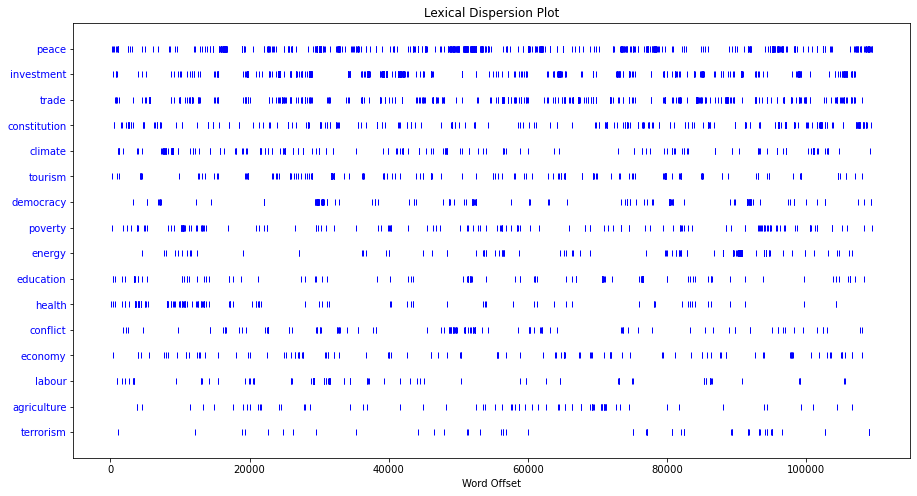

In [53]:
from nltk.draw.dispersion import dispersion_plot
all_tokens_corpora = nltk.Text(all_tokens)
#target_words = list(words_of_interest_df['Words of Interest'])
target_words = ['peace', 'investment', 'trade', 'constitution', 'climate', 'tourism', 'democracy', 
                'poverty', 'energy', 'education', 'health', 'conflict', 'economy', 'labour',
               'agriculture', 'terrorism']
all_tokens_corpora.dispersion_plot(target_words)

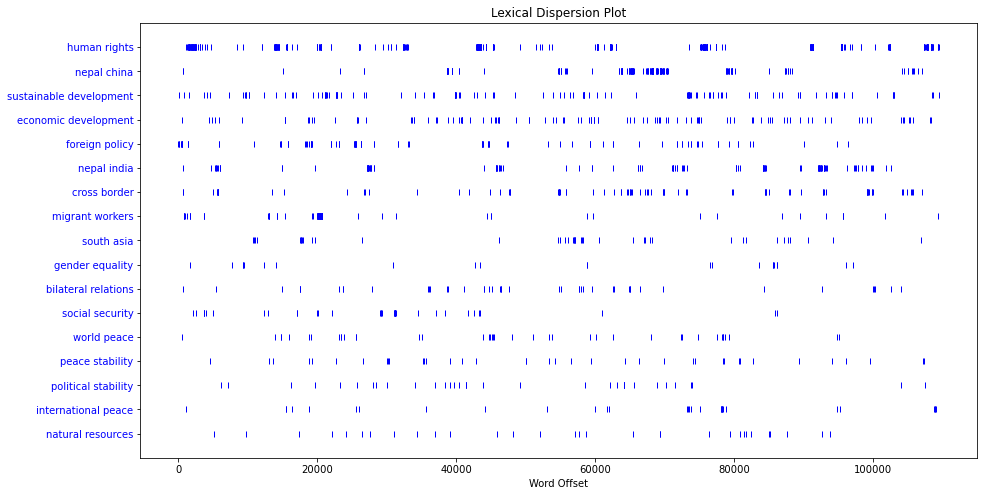

In [54]:
ng2_list_corpora = nltk.Text(ng2_list)
target_words = ['human rights','nepal china','sustainable development','economic development',
                             'foreign policy','nepal india','cross border','migrant workers','south asia','gender equality',
                              'bilateral relations','social security','world peace','peace stability','political stability',
                             'international peace', 'natural resources']
ng2_list_corpora.dispersion_plot(target_words)

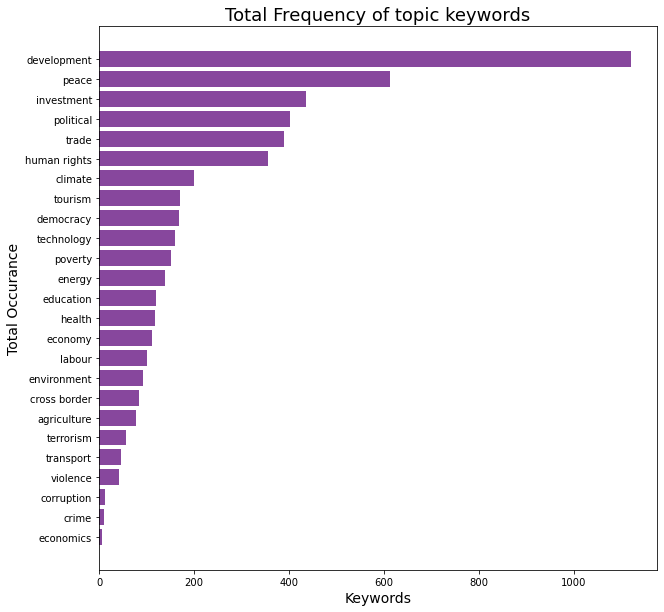

In [60]:
topics_words = ['development','economics','employement','environment','peace', 'investment', 'political', 'trade','poverty','democracy',
                             'tourism','climate','transport','labour','economy','health','technology','education','energy',
                             'agriculture','violence','terrorism','political','corruption','crime','human rights','cross border']
topics_df = words_of_interest_df[words_of_interest_df['Words of Interest'].isin(topics_words)]
topics_df = topics_df.sort_values('Frequency')
plt.figure(figsize=(10,10))
plt.barh(topics_df['Words of Interest'],topics_df['Frequency'],color='#87479d')
plt.title('Total Frequency of topic keywords', fontsize=18)
plt.xlabel('Keywords',fontsize=14)
plt.ylabel('Total Occurance',fontsize=14)
plt.savefig('../Graphs/total_topic_keywords_occurance.png')
plt.show()

In [61]:
def count_word(word):
  count_list = []
  for i in range(len(speech_tokens)):
    wordlist = []
    for token in speech_tokens[i]:
      if token in word:
        wordlist.append(word)
    count_list.append(len(wordlist))
  return count_list


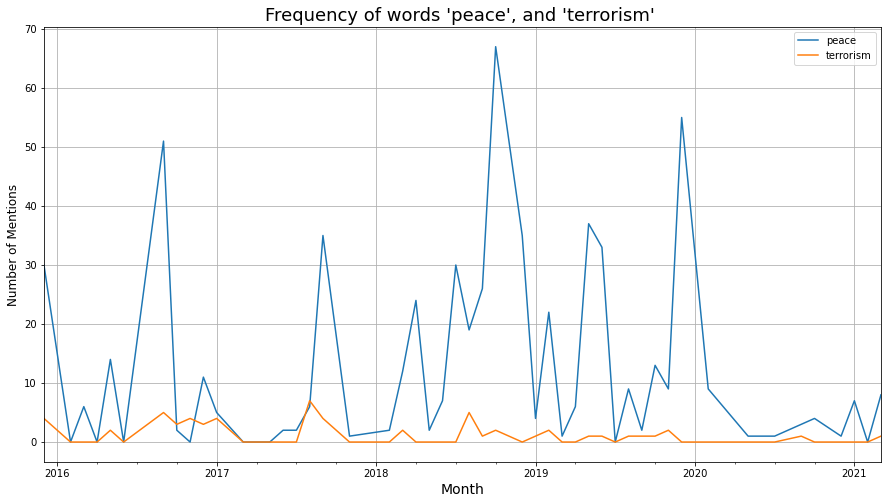

In [63]:
data['peace'] = count_word('peace')
data['terrorism'] = count_word('terrorism')
df = data.groupby('M/Y').agg(
                             peace = ('peace','sum'),
                             terrorism = ('terrorism','sum'))
df.plot()
plt.title("Frequency of words 'peace', and 'terrorism' ", fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Mentions', fontsize=12)
plt.grid(True)
plt.savefig('../Graphs/peace_terrorism_mentions.png')
plt.show()

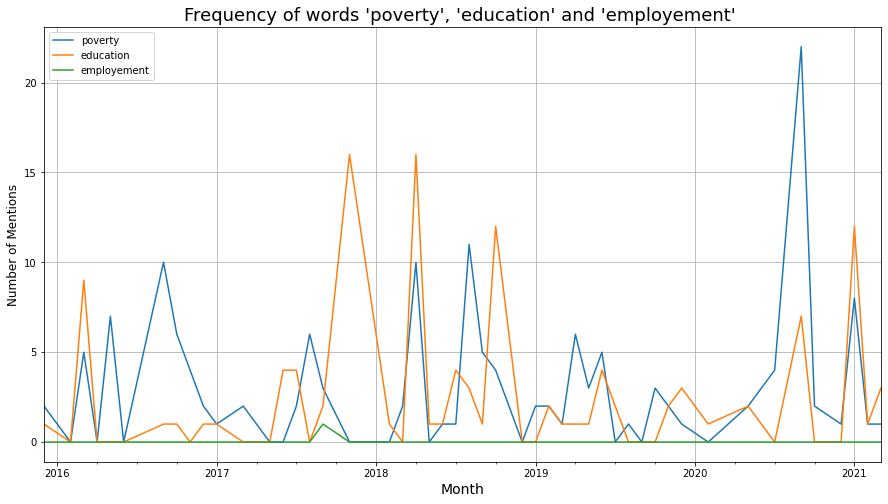

In [64]:
data['poverty'] = count_word('poverty')
data['education'] = count_word('education')
data['employement'] = count_word('employement')

df = data.groupby('M/Y').agg(
                             poverty = ('poverty','sum'),
                             education = ('education','sum'),
                             employement = ('employement','sum'))
df.plot()
plt.title("Frequency of words 'poverty', 'education' and 'employement' ", fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Mentions', fontsize=12)
plt.grid(True)
plt.savefig('../Graphs/pov_edu_emp.png')
plt.show()